In [ ]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from skimage import io
import re
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import tqdm
from IPython.display import clear_output

In [ ]:
!wget http://vision.cs.utexas.edu/projects/finegrained/utzap50k/ut-zap50k-images.zip
!unzip ut-zap50k-images.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/PUMA/8058592.265680.jpg  
  inflating: ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/PUMA/8058593.137771.jpg  
  inflating: ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/PUMA/8058593.382709.jpg  
  inflating: ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/PUMA/8058594.382712.jpg  
  inflating: ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/PUMA/8058594.382713.jpg  
  inflating: ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/PUMA/8058594.84280.jpg  
  inflating: ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/PUMA/8058597.104236.jpg  
  inflating: ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/PUMA/8058597.186729.jpg  
  inflating: ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/PUMA/8058601.173596.jpg  
  inflating: ut-zap50k-images/Shoes/Sneakers and Athletic Shoes/PUMA/8058601.382726.jpg  
  inflating: ut-zap50k-images/Sho

In [ ]:
# https://drive.google.com/file/d/1yU9MA5pbGx8ScsnQ0PoqQp4KgeEpvfqL/view?usp=sharing
meta = pd.read_csv("meta-data.csv")
print("Labels file found")
meta.head()

Labels file found


,CID,Category,SubCategory,HeelHeight,Insole,Closure,Gender,Material,ToeStyle
0,100627-72,Shoes,Oxfords,NaN,Leather,Lace up,Men,Leather,Capped Toe;Round Toe
1,100627-255,Shoes,Oxfords,NaN,Leather,Lace up,Men,Leather,Capped Toe;Round Toe
2,100657-72,Shoes,Oxfords,NaN,Leather;Padded;Removable,Lace up,Men,Leather,Capped Toe;Round Toe
3,100657-216,Shoes,Oxfords,NaN,Leather;Padded;Removable,Lace up,Men,Leather,Capped Toe;Round Toe
4,101026-3,Boots,Mid-Calf,1in - 1 3/4in,Leather;Padded,Pull-on,Men,Leather;Rubber,Square Toe;Closed Toe


In [ ]:
import os
from collections import defaultdict
import random

folder = "ut-zap50k-images"
classes = {}
numofpics = defaultdict(int)
img_paths = []
count = 0
for cat in os.listdir(folder):
  folder1 = folder + "/" + cat
  for subcat in os.listdir(folder1):
    folder2 = folder1 + "/" + subcat
    classes[cat + ", " + subcat] = count
    classes[count] = cat + ", " + subcat
    count += 1
    for brand in os.listdir(folder2):
      folder3 = folder2 + "/" + brand
      for pic in os.listdir(folder3):
        if random.randint(1,10) > 6:
          continue
        numofpics[cat + ", " + subcat] += 1
        img_paths.append(folder3 + "/" + pic)

print(len(img_paths))
numofpics

30014


defaultdict(int,
            {'Boots, Ankle': 3486,
             'Boots, Knee High': 1333,
             'Boots, Mid-Calf': 2826,
             'Boots, Over the Knee': 30,
             'Boots, Prewalker Boots': 1,
             'Sandals, Athletic': 11,
             'Sandals, Flat': 3292,
             'Sandals, Heel': 73,
             'Shoes, Boat Shoes': 388,
             'Shoes, Clogs and Mules': 867,
             'Shoes, Crib Shoes': 14,
             'Shoes, Firstwalker': 209,
             'Shoes, Flats': 2413,
             'Shoes, Heels': 3395,
             'Shoes, Loafers': 1746,
             'Shoes, Oxfords': 1213,
             'Shoes, Prewalker': 140,
             'Shoes, Sneakers and Athletic Shoes': 7793,
             'Slippers, Boot': 7,
             'Slippers, Slipper Flats': 771,
             'Slippers, Slipper Heels': 6})

In [ ]:
temp = numofpics.copy()
temp["Other"] = 0
for key, val in numofpics.items():
  if val < 1000:
    temp["Other"] += val
    temp.pop(key)
    classes.pop(key)
    classes[key] = 22

classes[22] = "Other"
classes["Other"] = 22

numofpics = temp.copy()

In [ ]:
num_classes = len(numofpics)

id2label = {x:i for i, x in enumerate(classes[x] for x in numofpics.keys())}
label2id = {i:x for i, x in id2label.items()}

In [ ]:
def get_label(img_path, meta):
  crop = re.search(r"/[0-9]+.[0-9]+", img_path).group(0)[1:]
  code = crop.replace('.','-')
  label = "Other"
  try:
    label = ", ".join(np.array(meta.loc[meta['CID'] == code])[0][1:3])
  except:
    print("Error in label at",img_path, code, np.array(meta.loc[meta['CID'] == code]))
  return label

In [ ]:
class ShoesDataset(Dataset):
  def __init__(self, csv_path, img_paths, transform):
        """
        Args:
            csv_path (string): Csv file with labels.
            img_paths (list): List of all images' path names.
            transform (callable): Optional transform to be applied
                on a sample.
        """
        self.csv = pd.read_csv("meta-data.csv")
        self.transform = transform
        tmpi = []
        self.labels = []
        for i in tqdm.notebook.tqdm(img_paths, "Loading"):
          img = io.imread(i)
          if img.shape != (102, 136, 3):
            continue
          self.labels.append(id2label[classes[get_label(i, self.csv)]])
          tmpi.append(transform(img))
        
        self.imgs = torch.stack(tmpi)
        

  def __len__(self):
      return len(self.imgs)

  def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()
      
      return [self.imgs[idx], self.labels[idx]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


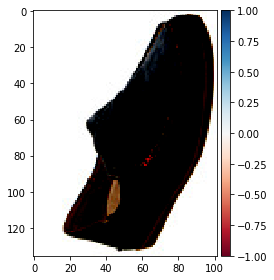

In [ ]:
transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

ds = ShoesDataset("meta-data.csv", img_paths, transform)
io.imshow(ds[0][0].cpu().numpy().T)

In [ ]:
class AE3(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        self.encoder_seq = nn.Sequential()

        self.encoder_seq.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=1)) # convolution
        self.encoder_seq.add_module('bn_conv1', nn.BatchNorm2d(6))
        self.encoder_seq.add_module('conv1_relu', nn.ReLU())
        self.encoder_seq.add_module('pool1', nn.MaxPool2d(kernel_size=3, stride=3))

        self.encoder_seq.add_module('conv1-5', nn.Conv2d(in_channels=6, out_channels=6, kernel_size=2, padding=1))
        self.encoder_seq.add_module('conv1-5_relu', nn.ReLU())

        self.encoder_seq.add_module('conv2', nn.Conv2d(in_channels=6, out_channels=10, kernel_size=3, padding=1)) # convolution
        self.encoder_seq.add_module('conv2_relu', nn.ReLU())
        self.encoder_seq.add_module('pool2', nn.MaxPool2d(kernel_size=3, stride=3, padding=0))

        self.encoder_seq.add_module('conv2-5', nn.Conv2d(in_channels=10, out_channels=10, kernel_size=2, padding=1))
        self.encoder_seq.add_module('conv2-5_relu', nn.ReLU())

        self.encoder_seq.add_module('conv3', nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3, padding=1)) # convolution
        self.encoder_seq.add_module('bn_conv2', nn.BatchNorm2d(16))
        self.encoder_seq.add_module('conv3_relu', nn.ReLU())
        self.encoder_seq.add_module('pool3', nn.MaxPool2d(kernel_size=2, stride=2, padding=0))


        self.decoder_seq = nn.Sequential()

        self.decoder_seq.add_module('deconv1', nn.ConvTranspose2d(in_channels=16, out_channels=10, kernel_size=2, stride=2, padding=0)) # convolution
        self.decoder_seq.add_module('deconv1_relu', nn.ReLU())

        self.decoder_seq.add_module('deconv1-5', nn.ConvTranspose2d(in_channels=10, out_channels=10, kernel_size=2, padding=0))
        self.decoder_seq.add_module('deconv1-5_relu', nn.ReLU())
        self.decoder_seq.add_module('bn_deconv1', nn.BatchNorm2d(10))

        self.decoder_seq.add_module('deconv2', nn.ConvTranspose2d(in_channels=10, out_channels=6, kernel_size=3, stride=3, padding=1)) # convolution
        self.decoder_seq.add_module('deconv2_relu', nn.ReLU())

        self.decoder_seq.add_module('deconv2-5', nn.ConvTranspose2d(in_channels=6, out_channels=6, kernel_size=2, padding=2))
        self.decoder_seq.add_module('deconv2-5_relu', nn.ReLU())
        self.decoder_seq.add_module('bn_deconv2', nn.BatchNorm2d(6))

        self.decoder_seq.add_module('deconv3', nn.ConvTranspose2d(in_channels=6, out_channels=3, kernel_size=3, stride=3,padding=(0,1))) # convolution
        self.decoder_seq.add_module('deconv3_relu', nn.ReLU())
    
    def encode(self, x):
      self.encoded = self.encoder_seq(x)
      return self.encoded

    def decode(self, x):
      self.decoded = self.decoder_seq(x)
      return self.decoded

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

model = AE3().cuda()

In [ ]:
from torchsummary import summary

summary(model.cuda(),(3,102,136))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 102, 136]             168
       BatchNorm2d-2          [-1, 6, 102, 136]              12
              ReLU-3          [-1, 6, 102, 136]               0
         MaxPool2d-4            [-1, 6, 34, 45]               0
            Conv2d-5            [-1, 6, 35, 46]             150
              ReLU-6            [-1, 6, 35, 46]               0
            Conv2d-7           [-1, 10, 35, 46]             550
              ReLU-8           [-1, 10, 35, 46]               0
         MaxPool2d-9           [-1, 10, 11, 15]               0
           Conv2d-10           [-1, 10, 12, 16]             410
             ReLU-11           [-1, 10, 12, 16]               0
           Conv2d-12           [-1, 16, 12, 16]           1,456
      BatchNorm2d-13           [-1, 16, 12, 16]              32
             ReLU-14           [-1, 16,

In [ ]:
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
trainset, testset = torch.utils.data.random_split(ds, [train_size, test_size])

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2
)

testloader = torch.utils.data.DataLoader(
    testset, batch_size=32, shuffle=False, num_workers=2
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

count_loss = nn.MSELoss()

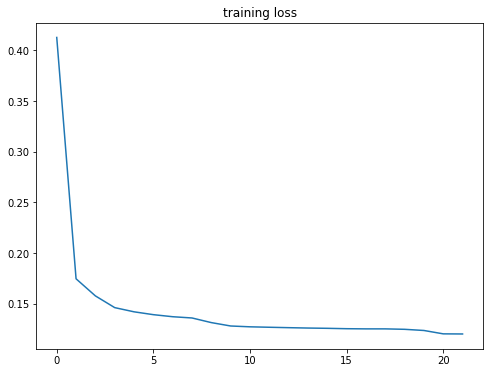

epoch : 22/500, loss = 0.120136
test loss: 0.12082373350858688 (updated 1 epochs ago)


KeyboardInterrupt: ignored

In [ ]:
epochs = 500
save = 25
test = 20
loss = []

for epoch in range(epochs):
    batchloss = 0
    model.train(True)
    for xbatch, _ in tqdm.notebook.tqdm(trainloader):  

        optimizer.zero_grad()
        outputs = model(xbatch.cuda())
        train_loss = count_loss(outputs.cuda(), xbatch.cuda())
        train_loss.backward()
        optimizer.step()
        
        batchloss += train_loss.item()
    

    loss.append(batchloss / len(trainloader))

    # save
    
    if epoch % save == 0:
      torch.save(model, f"conv-ae-v4-{epoch / save}.pt")

    # test loss

    
    if epoch % test == 0:
      with torch.no_grad():
        model.train(False)
        batchloss = 0
        for testx, testy in testloader:
          testx = testx.to("cuda")

          outputs = model(testx)
          batchloss += count_loss(outputs, testx)
          
        testloss = batchloss / len(testloader)

    # display 

    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss[-1]))

    fig, axs = plt.subplots(1, 1, figsize=(8, 6))
    clear_output(wait=True)
    axs.plot(loss)
    axs.set_title('training loss')
    plt.show()
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss[-1]))
    print(f"test loss: {testloss} (updated {epoch % test} epochs ago)")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([5, 3, 102, 136])


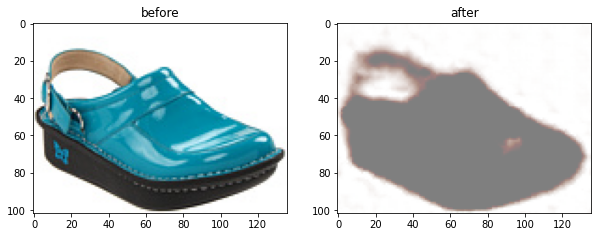

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


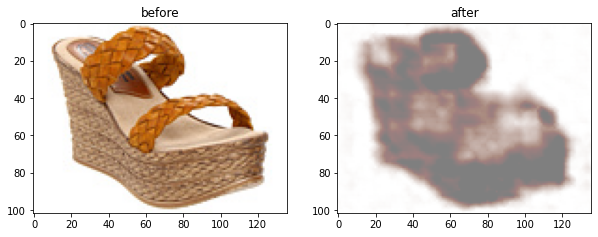

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


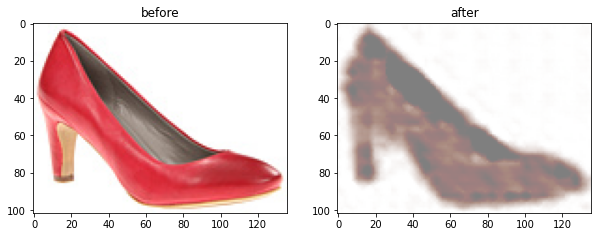

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


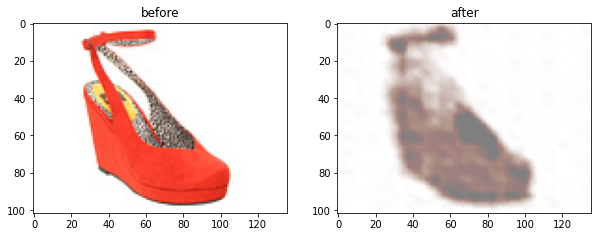

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


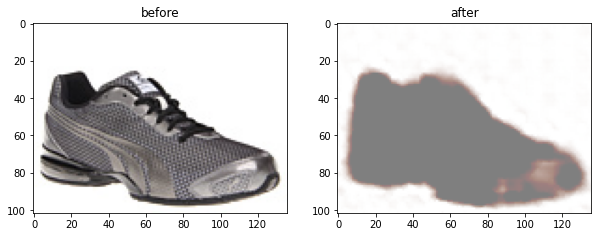

In [ ]:
examples = 5

with torch.no_grad():
  testx = next(iter(trainloader))[0][:examples].to("cuda")

  predicted = model(testx)
  print(predicted.shape)

  for i in range(examples):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(np.rot90(testx[i].to("cpu").numpy().T / 2 + 0.5,k=-1))
    axs[0].set_title('before')
    axs[1].imshow(np.rot90(predicted[i].to("cpu").numpy().T / 2 + 0.5,k=-1))
    axs[1].set_title('after')
    plt.show()

In [ ]:
samples = [model.encode(x.cuda()) for x,y in trainloader]

RuntimeError: ignored

In [ ]:
torch.save(model, "model.pt")

In [ ]:
model = torch.load("model.pt")

In [ ]:
def knn_samples(csv_path, img_paths):
  '''
      Input:
          csv_path (string): Csv file with labels.
          img_paths (list): List of all images' path names.
      Output:
          samples: array of encoded images
          labels: array of labels for samples
  '''
  samples = []
  labels = []

  transform = transforms.Compose(
      [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  csv = pd.read_csv(csv_path)
  
  for i in tqdm.notebook.tqdm(img_paths):
    img = io.imread(i)
    if img.shape != (102, 136, 3) or \
     i == "ut-zap50k-images/Boots/Mid-Calf/Primigi Kids/8022042.89.jpg":
            continue
    
    img = transform(img).reshape((1,3, 102, 136))
    with torch.no_grad():
      img = model.encode(img.cuda())
    
    samples.append(torch.flatten(img))
    labels.append(get_label(i, csv))

  return samples, labels

In [ ]:
samples, labels = knn_samples("meta-data.csv", img_paths)

In [ ]:
for i in range(len(samples)):
  samples[i] = samples[i].cpu().numpy()

samples = np.array(samples)

In [ ]:
samples = np.array(samples)

In [ ]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=5, radius=1).fit(samples)

In [ ]:
distances, indices = neigh.kneighbors(samples)


In [ ]:
! pip install hnswlib

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for hnswlib: filename=hnswlib-0.5.1-cp37-cp37m-linux_x86_64.whl size=1296753 sha256=d04b1ae91cd7060c7fcbb6ee6ee0f56b5b2a5ea88054353f5a445da027c2774a
  Stored in directory: /root/.cache/pip/wheels/46/7b/98/44c3a8a284506a54993f0b321e4a32a0c9e69215bbb72feff5
Successfully built hnswlib


In [ ]:
X = np.random.normal(0,1, (30000, 768))

neigh = NearestNeighbors(n_neighbors=5, radius=1).fit(X)


NameError: ignored

In [ ]:
samples.shape

(29933, 768)

In [ ]:
%%time
import hnswlib
import numpy as np

num_elements, dim = samples.shape

# Generating sample data

# We split the data in two batches:
data1 = samples[:num_elements // 2]
data2 = samples[num_elements // 2:]

# Declaring index
p = hnswlib.Index(space='l2', dim=dim)  # possible options are l2, cosine or ip

# Initing index
# max_elements - the maximum number of elements (capacity). Will throw an exception if exceeded
# during insertion of an element.
# The capacity can be increased by saving/loading the index, see below.
#
# ef_construction - controls index search speed/build speed tradeoff
#
# M - is tightly connected with internal dimensionality of the data. Strongly affects the memory consumption (~M)
# Higher M leads to higher accuracy/run_time at fixed ef/efConstruction

p.init_index(max_elements=num_elements//2, ef_construction=100, M=16)

# Controlling the recall by setting ef:
# higher ef leads to better accuracy, but slower search
p.set_ef(10)

# Set number of threads used during batch search/construction
# By default using all available cores
p.set_num_threads(4)


print("Adding first batch of %d elements" % (len(data1)))
p.add_items(data1)

# Query the elements for themselves and measure recall:
labels, distances = p.knn_query(data1, k=1)
print("Recall for the first batch:", np.mean(labels.reshape(-1) == np.arange(len(data1))), "\n")

# Serializing and deleting the index:
index_path='first_half.bin'
print("Saving index to '%s'" % index_path)
p.save_index(index_path)
del p

# Reiniting, loading the index
p = hnswlib.Index(space='l2', dim=dim)  # the space can be changed - keeps the data, alters the distance function.

print("\nLoading index from 'first_half.bin'\n")

# Increase the total capacity (max_elements), so that it will handle the new data
p.load_index("first_half.bin", max_elements = num_elements)

print("Adding the second batch of %d elements" % (len(data2)))
p.add_items(data2)

# Query the elements for themselves and measure recall:
labels, distances = p.knn_query(samples, k=2)
print("Recall for two batches:", np.mean(labels.reshape(-1) == np.arange(len(samples))), "\n")

Adding first batch of 15006 elements
Recall for the first batch: 0.9961348793815807 

Saving index to 'first_half.bin'

Loading index from 'first_half.bin'

Adding the second batch of 15007 elements
Recall for two batches: 0.0 

CPU times: user 10.5 s, sys: 149 ms, total: 10.7 s
Wall time: 5.6 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [ ]:
labels, distances = p.knn_query(samples, k=5)

In [ ]:
labels

array([[    0,  1047,   530,   980,  1086],
       [    1,   489,   482,    55,     7],
       [    2,  4989,   513,  1090,   532],
       ...,
       [29930, 28064, 24455, 21267, 10847],
       [29931, 13913, 13915,  8153, 23548],
       [29932, 28944, 12204, 28935, 15176]], dtype=uint64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


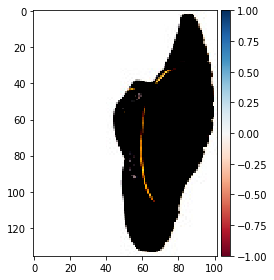

In [ ]:
io.imshow(ds[labels[ind][3]][0].to('cpu').numpy().T)

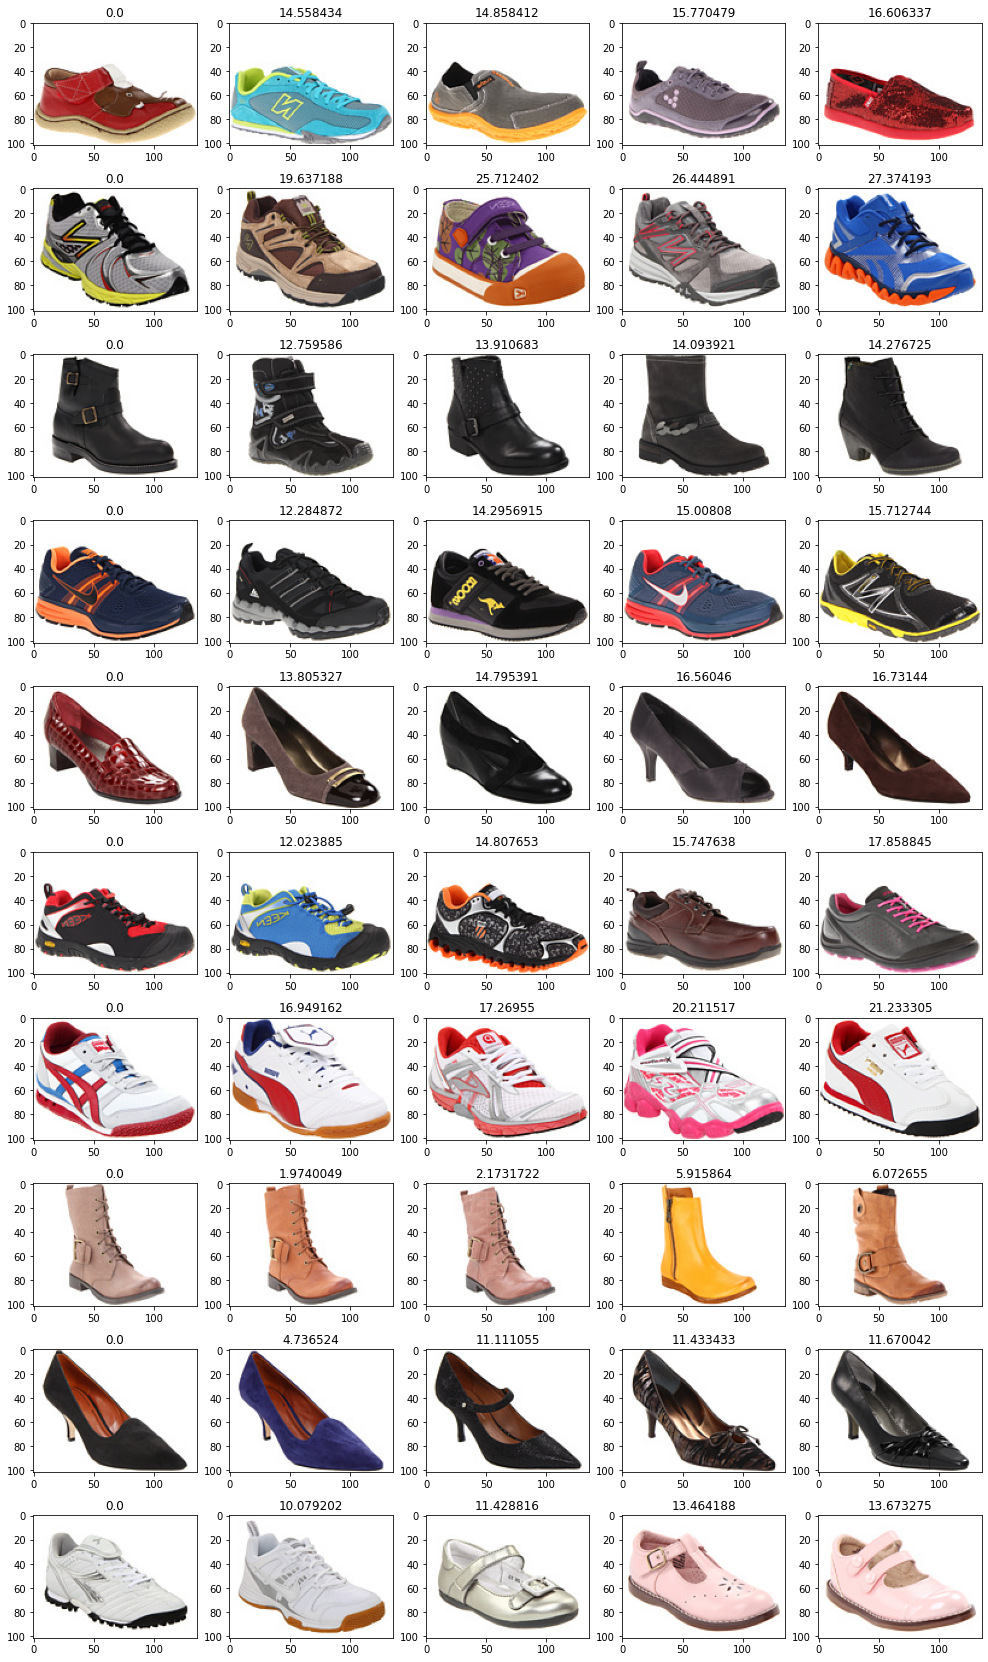

In [ ]:
examples = 10

fig, axs = plt.subplots(examples, labels.shape[1], figsize=(17,30))
for j in range(examples):
  ind = random.randint(0,labels.shape[0] - 1)
  for i in range(labels.shape[1]):
      axs[j][i].imshow(np.rot90(ds[labels[ind][i]][0].numpy().T / 2 + 0.5,k=-1))
      axs[j][i].set_title(distances[ind][i])

plt.show()